<a href="https://colab.research.google.com/github/lynn0503/NMA2022DL_Mohinga_Project/blob/main/human_rl_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using RL to Model Cognitive Tasks

**By Neurmatch Academy**

__Content creators:__ Morteza Ansarinia, Yamil Vidal

__Production editor:__ Spiros Chavlis


<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Objective

- This project aims to use behavioral data to train an agent and then use the agent to investigate data produced by human subjects. Having a computational agent that mimics humans in such tests, we will be able to compare its mechanics with human data.

- In another conception, we could fit an agent that learns many cognitive tasks that require abstract-level constructs such as executive functions. This is a multi-task control problem.




---
# Setup

In [1]:
# @title Install dependencies
# !pip install --upgrade pip setuptools wheel --quiet
!pip install dm-acme[jax,tensorflow] --quiet
!pip install dm-acme[envs] --quiet
!pip install dm-sonnet --quiet
!pip install trfl --quiet

     |████████████████████████████████| 314 kB 7.8 MB/s 
     |████████████████████████████████| 3.8 MB 41.6 MB/s 
     |████████████████████████████████| 72 kB 644 kB/s 
     |████████████████████████████████| 342 kB 48.3 MB/s 
     |████████████████████████████████| 197 kB 52.8 MB/s 
     |████████████████████████████████| 145 kB 56.1 MB/s 
     |████████████████████████████████| 117 kB 54.0 MB/s 
     |████████████████████████████████| 6.4 MB 23.8 MB/s 
     |████████████████████████████████| 4.0 MB 42.7 MB/s 
     |████████████████████████████████| 668.3 MB 18 kB/s 
     |████████████████████████████████| 5.7 MB 28.9 MB/s 
     |████████████████████████████████| 462 kB 51.5 MB/s 
     |████████████████████████████████| 596 kB 53.3 MB/s 
     |████████████████████████████████| 217 kB 41.6 MB/s 
     |████████████████████████████████| 51 kB 5.5 MB/s 
     |████████████████████████████████| 272 kB 39.8 MB/s 
     |████████████████████████████████| 18.8 MB 3.4 MB/s 
     |█████████████

In [2]:
# Imports

import time
import numpy as np
import pandas as pd
import sonnet as snt
import seaborn as sns
import matplotlib.pyplot as plt

import dm_env

import acme
from acme import specs
from acme import wrappers
from acme import EnvironmentLoop
from acme.agents.tf import dqn
from acme.utils import loggers
from acme.utils.observers import action_norm 
from tqdm import tqdm
from datetime import datetime 

In [3]:
# @title Figure settings
from IPython.display import clear_output, display, HTML
%matplotlib inline
sns.set()

---
# Background

- Cognitive scientists use standard lab tests to tap into specific processes in the brain and behavior. Some examples of those tests are Stroop, N-back, Digit Span, TMT (Trail making tests), and WCST (Wisconsin Card Sorting Tests).

- Despite an extensive body of research that explains human performance using descriptive what-models, we still need a more sophisticated approach to gain a better understanding of the underlying processes (i.e., a how-model).

- Interestingly, many of such tests can be thought of as a continuous stream of stimuli and corresponding actions, that is in consonant with the RL formulation. In fact, RL itself is in part motivated by how the brain enables goal-directed behaviors using reward systems, making it a good choice to explain human performance.

- One behavioral test example would be the N-back task.

  - In the N-back, participants view a sequence of stimuli, one by one, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedback is given at both timestep and trajectory levels.

  - The agent is rewarded when its response matches the stimulus that was shown N steps back in the episode. A simpler version of the N-back uses two-choice action schema, that is match vs non-match. Once the present stimulus matches the one presented N step back, then the agent is expected to respond to it as being a `match`.


- Given a trained RL agent, we then find correlates of its fitted parameters with the brain mechanisms. The most straightforward composition could be the correlation of model parameters with the brain activities.

## Datasets

- HCP WM task ([NMA-CN HCP notebooks](https://github.com/NeuromatchAcademy/course-content/tree/master/projects/fMRI))

Any dataset that used cognitive tests would work.
Question: limit to behavioral data vs fMRI?
Question: Which stimuli and actions to use?
classic tests can be modeled using 1) bounded symbolic stimuli/actions (e.g., A, B, C), but more sophisticated one would require texts or images (e.g., face vs neutral images in social stroop dataset)
The HCP dataset from NMA-CN contains behavioral and imaging data for 7 cognitive tests including various versions of N-back.

## N-back task

In the N-back task, participants view a sequence of stimuli, one per time, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedbacks are given at both timestep and trajectory levels.

In a typical neuro setup, both accuracy and response time are measured, but here, for the sake of brevity, we focus only on accuracy of responses.

---
# Cognitive Tests Environment

First we develop an environment in that agents perform a cognitive test, here the N-back.

## Human dataset

We need a dataset of human perfoming a N-back test, with the following features:

- `participant_id`: following the BIDS format, it contains a unique identifier for each participant.
- `trial_index`: same as `time_step`.
- `stimulus`: same as `observation`.
- `response`: same as `action`, recorded response by the human subject.
- `expected_response`: correct response.
- `is_correct`: same as `reward`, whether the human subject responded correctly.
- `response_time`: won't be used here.

Here we generate a mock dataset with those features, but remember to **replace this with real human data.**

### generate mock data

In [149]:
def generate_mock_nback_dataset(N=2,
                                n_participants=10,
                                n_trials=32,
                                stimulus_choices=list('ABCDEF'),
                                response_choices=['match', 'non-match']):
  """Generate a mock dataset for the N-back task."""

  n_rows = n_participants * n_trials

  participant_ids = sorted([f'sub-{pid}' for pid in range(1, n_participants + 1)] * n_trials)
  trial_indices = list(range(1, n_trials + 1)) * n_participants
  stimulus_sequence = np.random.choice(stimulus_choices, n_rows)

  # change stimuluse_sequence to control match and non-match number
  # stimulus_sequence=np.ones(n_rows)
  # match prob will be slightly higher than non-match prob
  # for i in range(n_rows):
  #   if i<N:
  #       stimulus_sequence[i]=np.random.choice(len(stimulus_choices))
  #   else:
  #       rand=np.random.random()
  #       if rand < 0.4:
  #           stimulus_sequence[i]=stimulus_sequence[i-N]
  #       else:
  #           stimulus_sequence[i]=np.random.choice(len(stimulus_choices))


  responses = np.random.choice(response_choices, n_rows)
  response_times = np.random.exponential(size=n_rows)

  df = pd.DataFrame({
      'participant_id': participant_ids,
      'trial_index': trial_indices,
      'stimulus': stimulus_sequence,
      'response': responses,
      'response_time': response_times
  })

  # mark matchig stimuli
  _nback_stim = df['stimulus'].shift(N)
  df['expected_response'] = (df['stimulus'] == _nback_stim).map({True: 'match', False: 'non-match'})

  df['is_correct'] = (df['response'] == df['expected_response'])

  # we don't care about burn-in trials (trial < N)
  df.loc[df['trial_index'] <= N, 'is_correct'] = True
  df.loc[df['trial_index'] <= N, ['response', 'response_time', 'expected_response']] = None

  return df



### Analyze mock data

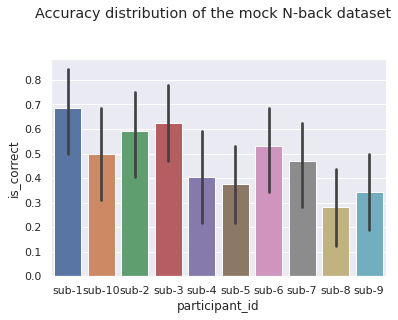

In [162]:

# ========
# now generate the actual data with the provided function and plot some of its features
N=2
episode_steps=500
mock_nback_data = generate_mock_nback_dataset()
mock_nback_data['is_correct'] = mock_nback_data['is_correct'].astype(int)


# sns.displot(data=mock_nback_data, x='response_time')
# plt.suptitle('response time distribution of the mock N-back dataset', y=1.01)
# plt.show()

# sns.displot(data=mock_nback_data, x='is_correct')
# plt.suptitle('Accuracy distribution of the mock N-back dataset', y=1.06)
# plt.show()

sns.barplot(data=mock_nback_data, y='is_correct', x='participant_id')
plt.suptitle('Accuracy distribution of the mock N-back dataset', y=1.06)
plt.show()

# mock_nback_data1.head()

# sns.displot(data=mock_nback_data, x='expected_response')
# plt.suptitle('correct-action distribution of the mock N-back dataset', y=1.06)
# plt.show()


## Implementation scheme


### Environment

The following cell implments N-back envinronment, that we later use to train a RL agent on human data. It is capable of performing two kinds of simulation:
- rewards the agent once the action was correct (i.e., a normative model of the environment).
- receives human data (or mock data if you prefer), and returns what participants performed as the observation. This is more useful for preference-based RL.

In [182]:
class NBack(dm_env.Environment):

  ACTIONS = ['match', 'non-match']

  def __init__(self,
               N=2,
               episode_steps=32,
               n_episodes=100,
               stimuli_choices=list('ABCDEFGHIJKLMN'),
               human_data=None,
               seed=1,
               ):
    """
    Args:
      N: Number of steps to look back for the matched stimuli. Defaults to 2 (as in 2-back).
      episode_steps
      stimuli_choices
      human_data
      seed

    """
    self.N = N
    self.episode_steps = episode_steps
    self.stimuli_choices = stimuli_choices
    self.stimuli = np.empty(shape=episode_steps)  # will be filled in the `reset()`
    self.current_episode = 0
    self._reset_next_step = True
    self.n_episodes=n_episodes
    # whether mimic humans or reward the agent once it responds optimally.
    if human_data is None:
      self._imitate_human = False
      self.human_data = None
      self.human_subject_data = None
    else:
      self._imitate_human = True
      self.human_data = human_data
      self.human_subject_data = None

    self._action_history = []
    self._reward_history = []


  def reset(self):

    self._reset_next_step = False
    self._current_step = 0
    self._action_history.clear()
    self._reward_history.clear()

    # generate a random sequence instead of relying on human data
    if self.human_data is None:
      # self.stimuli = np.random.choice(self.stimuli_choices, self.episode_steps)
      # FIXME This is a fix for acme & reverb issue with string observation. Agent should be able to handle strings
      self.stimuli = np.random.choice(len(self.stimuli_choices), self.episode_steps).astype(np.float32)
      # self.stimuli = np.empty(episode_steps)
      # # match prob will be slightly higher than non-match prob
      # for i in range(episode_steps):
      #   if i<N:
      #       self.stimuli[i]=np.random.choice(len(self.stimuli_choices))
      #   else:
      #       rand=np.random.random()
      #       if rand < 0.4:
      #           self.stimuli[i]=self.stimuli[i-N]
      #       else:
      #           self.stimuli[i]=np.random.choice(len(self.stimuli_choices))
      # print(self.stimuli)
    else:
      # randomly choose a subject from the human data and follow her trials and responses.
      # FIXME should we always use one specific human subject or randomly select one in each episode?
      self.human_subject_data = self.human_data.query('participant_id == participant_id.sample().iloc[0]',
                                                engine='python').sort_values('trial_index')
      self.stimuli = self.human_subject_data['stimulus'].to_list()
      self.stimuli = np.array([ord(s) - ord('A') + 1 for s in self.stimuli]).astype(np.float32)

    return dm_env.restart(self._observation())


  def _episode_return(self):
    if self._imitate_human:
      return np.mean(self.human_subject_data['response'] == self._action_history)
    else:
      return 0.0
    

  def step(self, action: int):
    if self._reset_next_step:
      return self.reset()

    agent_action = NBack.ACTIONS[action]

    if self._imitate_human:
      # if it was the same action as the human subject, then reward the agent
      human_action = self.human_subject_data['response'].iloc[self._current_step]
      step_reward = 0. if (agent_action == human_action) else -1.
    else:
      # assume the agent is rationale and doesn't want to reproduce human, reward once the response it correct
      expected_action = 'match' if (self.stimuli[self._current_step] == self.stimuli[self._current_step - self.N]) else 'non-match'
      step_reward = 0. if (agent_action == expected_action) else -1.
      
    self._action_history.append(agent_action)
    self._reward_history.append(step_reward)

    self._current_step += 1
    # Check for termination.
    if self._current_step == self.stimuli.shape[0]:
      self._reset_next_step = True
      self.current_episode += 1
      # we are using the mean of total time step rewards as the episode return
      # saving data
      df=pd.DataFrame()
      # print(len(self.stimuli),len(self._action_history))
      df['episode']=np.ones(self.episode_steps)*self.current_episode
      df['stimuli']=self.stimuli
      df['action']=self._action_history
      df['reward']=self._reward_history
      if self.current_episode == 1:
        mode='w'
        header=True
      else:
        mode='a'
        header=False
      # df.to_csv('data_lr.csv',header=header,index_label='trial',mode=mode)
      
      if self.current_episode==self.n_episodes:
        self.current_episode=0

      return dm_env.termination(reward=self._episode_return(),
                                observation=self._observation())
    else:
      return dm_env.transition(reward=step_reward,
                               observation=self._observation())

  def observation_spec(self):
    return dm_env.specs.BoundedArray(
        shape=self.stimuli.shape,
        dtype=self.stimuli.dtype,
        name='nback_stimuli', minimum=0, maximum=len(self.stimuli_choices) + 1)

  def action_spec(self):
    return dm_env.specs.DiscreteArray(
        num_values=len(NBack.ACTIONS),
        dtype=np.int32,
        name='action')

  def _observation(self):

    # agent observes only the current trial
    # obs = self.stimuli[self._current_step - 1]

    # agents observe stimuli up to the current trial
    obs = self.stimuli[:self._current_step+1].copy()
    obs = np.pad(obs,(0, len(self.stimuli) - len(obs)))

    return obs

  def plot_state(self):
    """Display current state of the environment.

     Note: `M` mean `match`, and `.` is a `non-match`.
    """
    stimuli = self.stimuli[:self._current_step - 1]
    actions = ['M' if a=='match' else '.' for a in self._action_history[:self._current_step - 1]]
    actions_binary = [1 if a=='M' else 0 for a in actions] 
    expected_actions = stimuli[:-self.N]==stimuli[self.N:]
    rewards = [1 if a==e else 0   for a in actions for e in expected_actions]
    return HTML(
        f'<b>Environment ({self.N}-back):</b><br />'
        f'<pre><b>Stimuli:</b> {"".join(map(str,map(int,stimuli)))}</pre>'
        f'<pre><b>Actions:</b> {"".join(actions)}</pre>'
        
    )
    
    # f'<pre><b>Rewards:</b> {"".join(map(str,reward)}</pre>'
    # print(self.N,'back')
    # print('stimuli: ',stimuli)
    # print('actions: ',actions)
    # print('answers: ',expected_actions)
    # print('rewards: ',rewards)


  @staticmethod
  def create_environment(N,episode_steps,n_episodes,human_data):
    """Utility function to create a N-back environment and its spec."""

    # Make sure the environment outputs single-precision floats.
    environment = wrappers.SinglePrecisionWrapper(NBack(N,episode_steps,n_episodes,human_data=None))

    # Grab the spec of the environment.
    environment_spec = specs.make_environment_spec(environment)

    return environment, environment_spec

#### Init ENV

In [120]:
# fitting parameters
N=2
n_episodes = 200
episode_steps= 32
# n_total_steps = 0
# log_loss = False
# n_steps = n_episodes * episode_steps

env, env_spec = NBack.create_environment(N=2,episode_steps=episode_steps,n_episodes=n_episodes)
# agent = RandomAgent(env_spec)

print('actions:\n', env_spec.actions)
print('observations:\n', env_spec.observations)
print('rewards:\n', env_spec.rewards)

actions:
 DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=1, num_values=2)
observations:
 BoundedArray(shape=(32,), dtype=dtype('float32'), name='nback_stimuli', minimum=0.0, maximum=15.0)
rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward')


### Define a random agent

For more information you can refer to NMA-DL W3D2 Basic Reinforcement learning.

In [131]:
class RandomAgent(acme.Actor):

  def __init__(self, environment_spec):
    """Gets the number of available actions from the environment spec."""
    self._num_actions = environment_spec.actions.num_values

  def select_action(self, observation):
    """Selects an action uniformly at random."""
    action = np.random.randint(self._num_actions)
    return action

  def observe_first(self, timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def observe(self, action, next_timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def update(self):
    """Does not update as the RandomAgent does not learn from data."""
    pass

### Define DQN

In [9]:
def dqn_make_network(action_spec: specs.DiscreteArray) -> snt.Module:
  return snt.Sequential([
      snt.Flatten(),
      snt.nets.MLP([50, 50, 50, 50, action_spec.num_values]),
  ])


### Define DRQN

In [10]:
# add recurrent layer to dqn
# r2d2 receive sequence data
from acme.agents.tf import r2d2
def r2d2_make_network(action_spec: specs.DiscreteArray) -> snt.Module:
  return snt.DeepRNN([
            snt.Flatten(),
            snt.LSTM(2),
            snt.nets.MLP([50, 50, action_spec.num_values])
            ])


## Plot function

In [12]:
# plot moving average
def moving_average(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, 'same')

# plot reward by episode
def plot_reward_by_episode(logs_dict):
    for key, val in logs_dict.items():
        logs=logs_dict[key]
        reward_ma=moving_average(logs['episode_return'],10)
        plt.plot(reward_ma)

    plt.ylabel("episode reward")
    plt.xlabel("episode")
    plt.legend(['RANDOM','DQN','DRQN'])
    plt.title("total reward within episode")


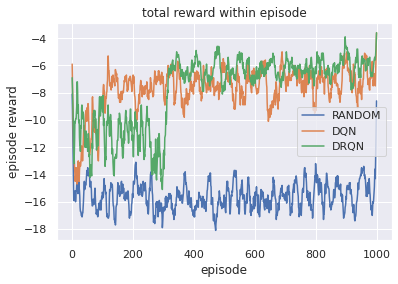

In [ ]:
# test plot function 
# N = 2
# n_episodes = 1000
# episode_steps= 32
plot_reward_by_episode(logs_dict)

## Test agents

### test Random Agent

In [ ]:
# all_returns = []
# # main loop
# for episode in range(n_episodes):
#   episode_steps = 0
#   episode_return = 0
#   episode_loss = 0

#   start_time = time.time()

#   timestep = env.reset()

#   # Make the first observation.
#   agent.observe_first(timestep)

#   # Run an episode
#   while not timestep.last():

#     # DEBUG
#     # print(timestep)

#     # Generate an action from the agent's policy and step the environment.
#     action = agent.select_action(timestep.observation)
#     timestep = env.step(action)

#     # Have the agent observe the timestep and let the agent update itself.
#     agent.observe(action, next_timestep=timestep)
#     agent.update()

#     # Book-keeping.
#     episode_steps += 1
#     n_total_steps += 1
#     episode_return += timestep.reward

#     if log_loss:
#       episode_loss += agent.last_loss

#     if n_steps is not None and n_total_steps >= n_steps:
#       break

#   # Collect the results and combine with counts.
#   steps_per_second = episode_steps / (time.time() - start_time)
#   result = {
#       'episode': episode,
#       'episode_length': episode_steps,
#       'episode_return': episode_return,
#   }
#   if log_loss:
#     result['loss_avg'] = episode_loss/episode_steps

#   all_returns.append(episode_return)

#   display(env.plot_state())
#   # Log the given results.
#   print(result)

#   if n_steps is not None and n_total_steps >= n_steps:
#     break

# clear_output()

# # Histogram of all returns
# plt.figure()
# sns.histplot(all_returns, stat="density", kde=True, bins=12)
# plt.xlabel('Return [a.u.]')
# plt.ylabel('Density')
# plt.show()

ValueError: ignored

**Note:** You can simplify the environment loop using [DeepMind Acme](https://github.com/deepmind/acme).

### test DQN

In [ ]:
# # test dqn
# # construct a DQN agent
agent = dqn.DQN(
    environment_spec=env_spec,
    network=dqn_make_network(env_spec.actions),
    epsilon=[0.1],
    discount=0.01,
    logger=loggers.InMemoryLogger(),
    checkpoint=False,
)

Now, we run the environment loop with the DQN agent and print the training log.

Text(0.5, 1.0, 'DQN reward by episode')

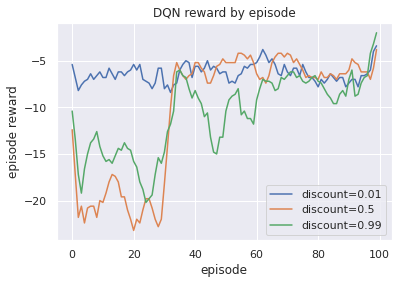

In [ ]:
# # training loop


for discount in [0.1,0.5,0.9]:
  agent = dqn.DQN(
    environment_spec=env_spec,
    network=dqn_make_network(env_spec.actions),
    epsilon=[0.1],
    discount=discount,
    logger=loggers.InMemoryLogger(),
    checkpoint=False)
  loop = EnvironmentLoop(env, agent, logger=loggers.InMemoryLogger())
  loop.run(n_episodes)
  logs_dqn = pd.DataFrame(loop._logger._data)
  episode_return=logs_dqn['episode_return']
  plt.plot(moving_average(episode_return,5),label="discount="+str(discount))

plt.legend()
plt.ylabel("episode reward")
plt.xlabel("episode")
plt.title("DQN reward by episode")
# print logs
# logs_dqn = pd.DataFrame(loop._logger._data)
# logs_dqn.tail()

### test DRQN

INFO:tensorflow:Assets written to: /root/acme/27a4cebc-09a6-11ed-8643-0242ac1c0002/snapshots/network/assets


INFO:tensorflow:Assets written to: /root/acme/27a4cebc-09a6-11ed-8643-0242ac1c0002/snapshots/network/assets


INFO:tensorflow:Assets written to: /root/acme/27a4cebc-09a6-11ed-8643-0242ac1c0002/snapshots/network/assets


INFO:tensorflow:Assets written to: /root/acme/27a4cebc-09a6-11ed-8643-0242ac1c0002/snapshots/network/assets


Text(0.5, 1.0, 'DRQN reward by episode')

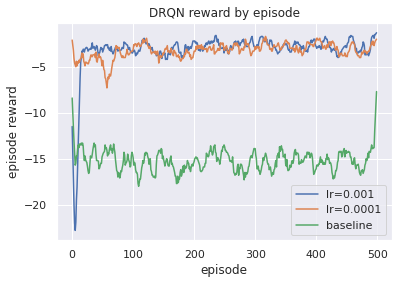

In [121]:
# # test DRQN
# # construct a DRQN agent

n_episodes = 500
# epsilon default 0.05
for learning_rate in [1e-3,1e-4]:
  agent_r2d2 = r2d2.R2D2(
      environment_spec=env_spec,
      network=r2d2_make_network(env_spec.actions),
      burn_in_length=10,
      trace_length=2,
      replay_period=10,
      epsilon=0.05,
      learning_rate=learning_rate,
      min_replay_size=32,
      logger=loggers.InMemoryLogger(),
      checkpoint=False)

  loop = EnvironmentLoop(env, agent_r2d2, logger=loggers.InMemoryLogger())
  loop.run(n_episodes)

  logs_r2d2 = pd.DataFrame(loop._logger._data)
  episode_return=logs_r2d2['episode_return']
  plt.plot(moving_average(episode_return,10),label="lr="+str(learning_rate))

agent_random = RandomAgent(env_spec)
loop = EnvironmentLoop(env, agent_random, logger=loggers.InMemoryLogger())
loop.run(n_episodes)
logs_random = pd.DataFrame(loop._logger._data)
episode_return=logs_random['episode_return']
plt.plot(moving_average(episode_return,10),label="baseline")

plt.legend()
plt.ylabel("episode reward")
plt.xlabel("episode")
plt.title("DRQN reward by episode")

# print logs
# logs_r2d2 = pd.DataFrame(loop._logger._data)
# logs_r2d2.tail()

INFO:tensorflow:Assets written to: /root/acme/519f3846-0975-11ed-83b6-0242ac1c0002/snapshots/network/assets
INFO:tensorflow:Assets written to: /root/acme/519f3846-0975-11ed-83b6-0242ac1c0002/snapshots/network/assets
INFO:tensorflow:Assets written to: /root/acme/519f3846-0975-11ed-83b6-0242ac1c0002/snapshots/network/assets


Text(0.5, 1.0, 'DRQN reward by episode')

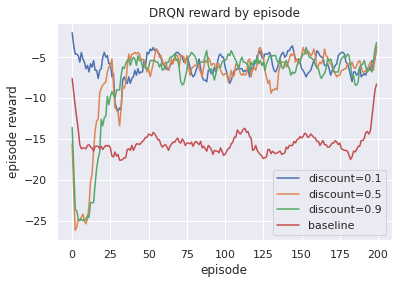

In [ ]:
# # test DRQN
# # construct a DRQN agent

n_episodes = 200
# epsilon default 0.05
for discount in [0.1,0.5,0.9]:
  agent_r2d2 = r2d2.R2D2(
      environment_spec=env_spec,
      network=r2d2_make_network(env_spec.actions),
      burn_in_length=10,
      trace_length=2,
      replay_period=10,
      epsilon=0.05,
      discount=discount,
      learning_rate=1e-4,
      min_replay_size=32,
      logger=loggers.InMemoryLogger(),
      checkpoint=False)

  loop = EnvironmentLoop(env, agent_r2d2, logger=loggers.InMemoryLogger())
  loop.run(n_episodes)

  logs_r2d2 = pd.DataFrame(loop._logger._data)
  episode_return=logs_r2d2['episode_return']
  plt.plot(moving_average(episode_return,5),label="discount="+str(discount))

agent_random = RandomAgent(env_spec)
loop = EnvironmentLoop(env, agent_random, logger=loggers.InMemoryLogger())
loop.run(n_episodes)
logs_random = pd.DataFrame(loop._logger._data)
episode_return=logs_random['episode_return']
plt.plot(moving_average(episode_return,10),label="baseline")

plt.legend()
plt.ylabel("episode reward")
plt.xlabel("episode")
plt.title("DRQN reward by episode")

# print logs
# logs_r2d2 = pd.DataFrame(loop._logger._data)
# logs_r2d2.tail()

# Playground

## test different parameters

In [ ]:
# test 5 back

N = 2
n_episodes = 100
episode_steps= 32
n_total_steps = 0
log_loss = False
n_steps = n_episodes * episode_steps
# mock data
# mock_nback_data = generate_mock_nback_dataset(N=N,n_trials=episode_steps)
# environment
env, env_spec = NBack.create_environment(N=N,episode_steps=episode_steps)
obs = action_norm.ActionNormObserver()

# agent
agent_random = RandomAgent(env_spec)

agent_dqn = dqn.DQN(
        environment_spec=env_spec,
        network=dqn_make_network(env_spec.actions),
        epsilon=[0.1],
        logger=loggers.InMemoryLogger(),
        checkpoint=False,
)

agent_drqn = r2d2.R2D2(
    environment_spec=env_spec,
    network=r2d2_make_network(env_spec.actions),
    burn_in_length=10,
    trace_length=2,
    replay_period=10,
    epsilon=[0.1],
    logger=loggers.InMemoryLogger(),
    checkpoint=False,
)

# training loop
agent_dict= {'RANDOM':agent_random,
    'DQN':agent_dqn,
    'DRQN':agent_drqn}
logs_dict = {}

for key, agent in tqdm(agent_dict.items()):
    loop = EnvironmentLoop(env, agent, 
                logger=loggers.InMemoryLogger())
    loop.run(n_episodes)
    logs_dict[key] = pd.DataFrame(loop._logger._data)
    # print(logs_dict[key].tail(5))



  0%|          | 0/3 [00:00<?, ?it/s]


TypeError: ignored

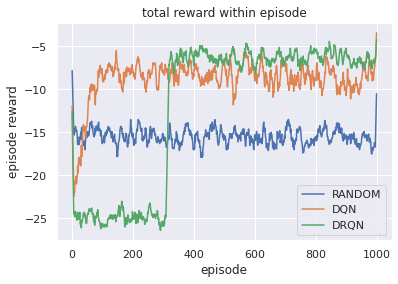

In [ ]:
plot_reward_by_episode(logs_dict)

In [ ]:
env.plot_state()

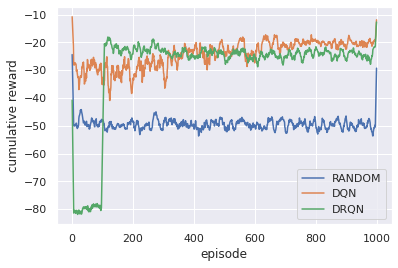

In [ ]:
# N = 2
# n_episodes = 1000
# episode_steps= 100
for key, val in logs_dict.items():
    logs=logs_dict[key]
    reward_ma=moving_average(logs['episode_return'],10)
    plt.plot(reward_ma)

plt.ylabel("cumulative reward")
plt.xlabel("episode")
plt.legend(['RANDOM','DQN','DRQN'])
# because episode_steps too large, 
# DQN learn the best policy within the first episode 
# so reward is not increasing by episode

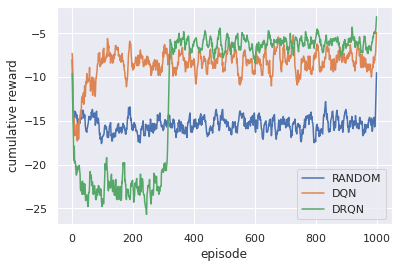

In [ ]:
# N = 2
# n_episodes = 1000
# episode_steps= 32
for key, val in logs_dict.items():
    logs=logs_dict[key]
    reward_ma=moving_average(logs['episode_return'],10)
    plt.plot(reward_ma)

plt.ylabel("cumulative reward")
plt.xlabel("episode")
plt.legend(['RANDOM','DQN','DRQN'])
# episode_steps is small and dqn is learning by episode

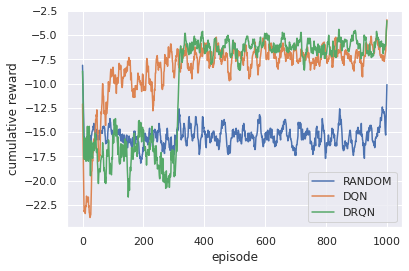

In [ ]:
# N = 5
# n_episodes = 1000
# episode_steps= 32

for key, val in logs_dict.items():
    logs=logs_dict[key]
    reward_ma=moving_average(logs['episode_return'],10)
    plt.plot(reward_ma)

plt.ylabel("cumulative reward")
plt.xlabel("episode")
plt.legend(['RANDOM','DQN','DRQN'])
plt.title("5-back")

## error pattern

### episode analysis

In [ ]:
logs_drqn=logs_dict['DRQN']
# dataframe
print(logs_dqn.tail(10))

     episode_length episode_return  steps_per_second  episodes  steps
990              32           -4.0        346.219121       991  31712
991              32           -8.0        336.968010       992  31744
992              32           -5.0        352.724656       993  31776
993              32           -7.0        350.254117       994  31808
994              32           -6.0        321.221841       995  31840
995              32          -10.0        347.744952       996  31872
996              32           -4.0        347.761170       997  31904
997              32           -8.0        346.695790       998  31936
998              32           -5.0        328.387926       999  31968
999              32           -9.0        321.985510      1000  32000


### trial analysis

In [49]:
df=pd.read_csv('DRQN_2back_500episodes_32steps.csv')
df.head()

,trial,episode,stimuli,action,reward
0,0,1.0,1.0,non-match,-1.0
1,1,1.0,5.0,match,-1.0
2,2,1.0,0.0,non-match,0.0
3,3,1.0,2.0,match,-1.0
4,4,1.0,0.0,match,0.0


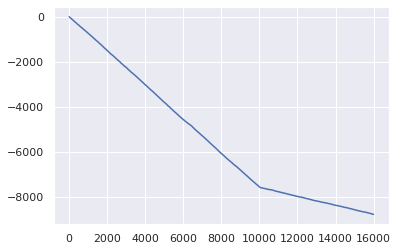

In [34]:
plt.plot(np.cumsum(df['reward']))

In [35]:
df_episode = df.groupby(["episode"]).sum()

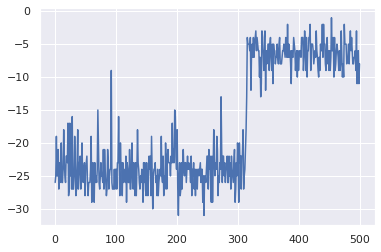

In [38]:
plt.plot(df_episode['reward'])

Text(0.5, 0.98, 'error step index distribution before and after jump')

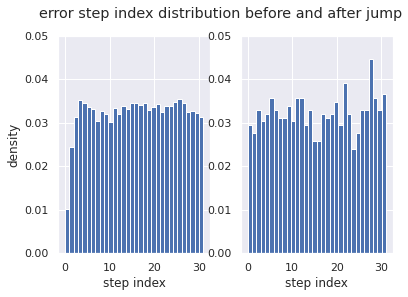

In [42]:
# plot error idx
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))

error_idx=df['trial'][df['reward']==-1][df['episode']<310]
ax1.hist(error_idx,bins=episode_steps,density=True)
ax1.set_ylim(0,0.05)
ax1.set_ylabel('density')
ax1.set_xlabel('step index')


error_idx=df['trial'][df['reward']==-1][df['episode']>320]
ax2.hist(error_idx,bins=episode_steps,density=True)
ax2.set_ylim(0,0.05)
ax2.set_xlabel('step index')


fig.suptitle('error step index distribution before and after jump')

In [47]:
df_best= df[df['episode']>400]

Text(0.5, 1.0, 'error distribution of best policy')

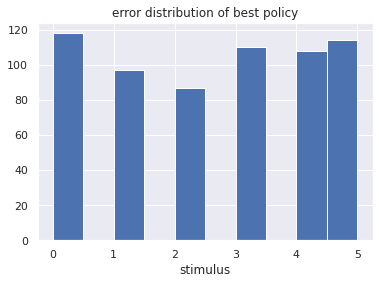

In [50]:
error_sti=df_best['stimuli'][df['reward']==-1]
plt.hist(error_sti)
# ax2.set_ylim(0,0.05)
plt.xlabel('stimulus')
plt.title('error distribution of best policy')

In [56]:
df['action binary']=[0 if x=='match' else -1 for x in df['action']]
df['expected binary']= df['action binary']==df['reward']
df['expected action']=['match' if x==True else 'non-match' for x in df['expected binary']]
df.head()

,trial,episode,stimuli,action,reward,action binary,expected bianry,expected binary,expected action
0,0,1.0,1.0,non-match,-1.0,-1,True,True,match
1,1,1.0,5.0,match,-1.0,0,False,False,non-match
2,2,1.0,0.0,non-match,0.0,-1,False,False,non-match
3,3,1.0,2.0,match,-1.0,0,False,False,non-match
4,4,1.0,0.0,match,0.0,0,True,True,match


Text(0.5, 1.0, 'expected action distribution of best policy')

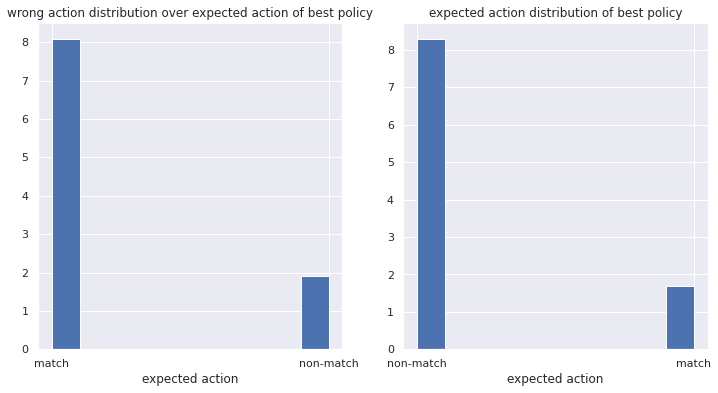

In [73]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

error_action=df['expected action'][df['reward']==-1][df['episode']>400]
ax1.hist(error_action,density=True)
ax1.set_xlabel('expected action')
ax1.set_title('wrong action distribution over expected action of best policy')

exp_action=df['expected action'][df['episode']>400]
ax2.hist(exp_action,density=True)
ax2.set_xlabel('expected action')
ax2.set_title('expected action distribution of best policy')

## feed mock data to agent

In [187]:
N=2
n_episodes = 500
episode_steps=32

mock_nback_data = generate_mock_nback_dataset(
    N=2,n_participants=n_episodes,n_trials=episode_steps)

env, env_spec = NBack.create_environment(
    N=2,episode_steps=episode_steps,n_episodes=n_episodes,
    human_data=mock_nback_data)

agent = dqn.DQN(
    environment_spec=env_spec,
    network=dqn_make_network(env_spec.actions),
    epsilon=[0.05],
    discount=0.5,
    learning_rate=1e-5,
    min_replay_size=32,
    logger=loggers.InMemoryLogger(),
    checkpoint=False)

loop = EnvironmentLoop(env, agent, logger=loggers.InMemoryLogger())
loop.run(n_episodes)
logs_dqn = pd.DataFrame(loop._logger._data)
logs_dqn.head()

env, env_spec = NBack.create_environment(
    N=2,episode_steps=episode_steps,n_episodes=n_episodes,
    human_data=None)

agent_optimal = dqn.DQN(
    environment_spec=env_spec,
    network=dqn_make_network(env_spec.actions),
    epsilon=[0.05],
    discount=0.5,
    learning_rate=1e-5,
    min_replay_size=32,
    logger=loggers.InMemoryLogger(),
    checkpoint=False)

loop = EnvironmentLoop(env, agent_optimal, logger=loggers.InMemoryLogger())
loop.run(n_episodes)
logs_dqn_optimal = pd.DataFrame(loop._logger._data)
logs_dqn_optimal.head()

agent_random = RandomAgent(env_spec)
loop = EnvironmentLoop(env, agent_random, logger=loggers.InMemoryLogger())
loop.run(n_episodes)
logs_random = pd.DataFrame(loop._logger._data)
episode_return=logs_random['episode_return']



Text(0.5, 1.0, 'DQN')

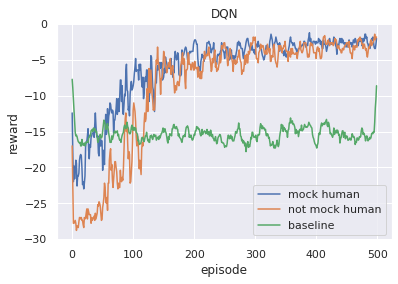

In [189]:
plt.plot(moving_average(logs_dqn['episode_return'],5),label='mock human')
plt.plot(moving_average(logs_dqn_optimal['episode_return'],5),label='not mock human')
plt.plot(moving_average(episode_return,10),label="baseline")
plt.legend()
plt.xlabel('episode')
plt.ylabel('reward')
plt.title('DQN')

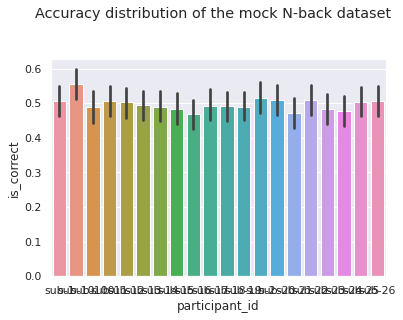

In [173]:

mock_nback_data = generate_mock_nback_dataset(
    N=2,n_participants=n_episodes,n_trials=episode_steps)

df=mock_nback_data.head(10000)
                
sns.barplot(data=df, y='is_correct', x='participant_id')
plt.suptitle('Accuracy distribution of the mock N-back dataset', y=1.06)
plt.show()

In [190]:
mock_nback_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   participant_id     16000 non-null  object 
 1   trial_index        16000 non-null  int64  
 2   stimulus           16000 non-null  object 
 3   response           15000 non-null  object 
 4   response_time      15000 non-null  float64
 5   expected_response  15000 non-null  object 
 6   is_correct         16000 non-null  bool   
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 765.8+ KB
